# 개체명 인식을 위한 양방향 LSTM 모델

## LSTM

**입력 시퀀스의 시점(time step_이 길어질수록 앞쪽의 데이터가 뒤쪽으로 잘 전달되지 않아 학습 능력이 떨어진다. RNN을 다층 구조로 쌓으면 입력과 출력 데이터 사이의 연관 관계가 줄어들어 장기 의존성 (Long-Term Dependency) 문제가 생긴다.** 이런 문제를 보완하기 위해 기존 RNN을 변형해 LSTM(Lont Short Term Memory)을 사용한다.

LSTM은 기본적인 RNN의 은닉 상태를 계산하는 방식에 변화가 있으며, 은닉 상탯값 이외에 셀 상탯값 이외에 셀 상탯값이 추가되었다. LSTM은 은닉 상탯값과 셀 상탯값을 계산하기 위한 다음 그림과 같은 3개의 게이트(Gate)가 추가되었다.

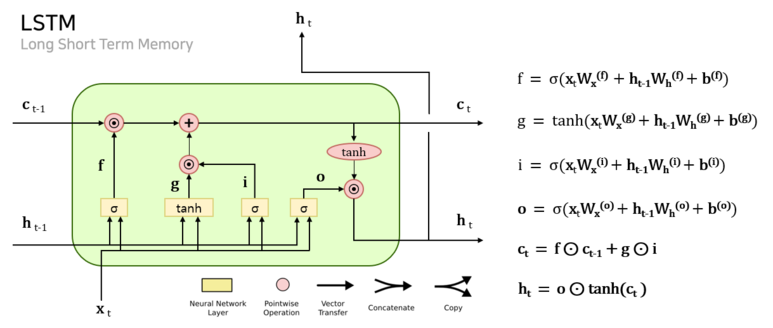

LSTM은 입력 게이트(Input Gate), 삭제 게이트(Forget Gate), 출력 게이트(Output Gate)로 구성되어 있다. 

### 입력 게이트
입력 게이트는 현재 정보를 얼마나 기억할지 결정하는 게이트이다. 현재 시점의 입력값(Xt)과 이전 시점의 은닉 상탯값(ht-1)을 연관된 가중치로 곱해 2개의 활성화 함수로 계산한다. 이를 통해 기억할 정보의 양을 결정한다. 수식에서 σ(시그마)는 시그모이드 함수, tanh는 하이퍼블릭 탄젠트 함수를 의미한다.

it는 시그모이드 함수의 결괏값으로 출력값의 범위가 0~1 사이며, gt는 하이퍼블릭 탄젠트 함수의 결괏값으로 출력값의 범위가 -1~1 사이이다. 이 두 값의 곱을 통해 현재 입력되는 정보를 얼마만큼 다음 시점의 셀 상탯값(Ct)으로 전달할지 결정한다.

### 삭제 게이트
삭제 게이트는 이전 시점의 셀 상탯값을 삭제하기 위해 사용한다. 현재 시점의 입력값(Xt)과 이전 시점의 은닉 상탯값 (ht-1)을 시그모이드 함수를 통해 0~1 사이의 값으로 출력한다. 즉, 삭제 게이트의 결괏값(ft)으로 기억된 정보를 얼마나 삭제할지 강도를 결정한다. 

입력 게이트와 삭제 게이트의 결괏값으로 현재 시점의 셀 상태를 계산한다. 셀 상탯값 ct는 LSTM 계층의 마지막 단계까지 오랫동안 정보 특성을 기억할 수 있기 때문에 장기 상태라고 부르기도 한다. 셀 상태는 입력 게이트와 삭제 게이트의 결과에 영향이 미치는데, 삭제 게이트는 이전 시점의 입력을 얼마나 반영할지, 입력 게이트는 현재 시점의 입력을 얼마나 반영할지 결정한다.

### 출력 게이트
마지막으로 LSTM의 출력 게이트와 은닉 상태에 대해 살펴보자. 출력 게이트의 결괏값(Ot)은 현재 시점의 은닉 상태(ht)를 결정하는데 사용되며, 해당 값은 전달되는 메모리 셀이 많아질수록 정보 유실이 크기 때문에 단기 상태라고 부른다. 단기 상태(은닉 상태)는 장기 상태(셀 상탯값)에 영향을 받는 구조이다.

다음은 특정 범위만큼의 sin 파형 시퀀스를 학습해 다음 스텝의 파형을 예측하는 LSTM 모델을 구현한다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM

In [3]:
# time step만큼 시퀀스 데이터 분리
def split_sequence(sequence, step):
  x, y = list(), list() # 입력 인자로 넘어온 리스트 데이터를 

  for i in range(len(sequence)): #순차적으로 step 크기만큼 나눠 RNN 모델에 사용될
    end_idx = i+step
    if end_idx > len(sequence)-1:
      break

    seq_x, seq_y = sequence[i:end_idx], sequence[end_idx] # 시퀀스 (x)와 출력값(y)을 넘파이 배열로 만든다.
    x.append(seq_x)
    y.append(seq_y)

  return np.array(x), np.array(y)

In [4]:
# sin 함수 학습 데이터
# -10에서 +10 사이의 x축 범위를 가지는 sin() 함수 값을 0.1 단위로 증가시켜 train_y 리스트에 저장한다.
# train_y 리스트는 RNN 모델 학습에 필요한 학습 데이터셋이다.
x = [i for i in np.arange(start=-10, stop=10, step=0.1)] 
train_y = [np.sin(i) for i in x]

In [5]:
# 하이퍼 파라미터
n_timesteps = 15 #입력 시퀀스 길이를 15로 정의한다. 이 때, 15만큼 RNN 메모리 셀이 생성된다.
n_features = 1 # 입력 벡터의 차원크기는 1로 정의한다.

In [6]:
# 시퀀스 나누기
# train_x.shape => (samples, timesteps)
# train_y.shape => (samples)

train_x, train_y = split_sequence(train_y, step=n_timesteps) # sin 파형의 학습 데이터가 들어 있는 train_y 리스트에서 n_timesteps만큼 나눠서 입력 시퀀스를 생성한다.
print("shape x : {}".format(train_x.shape, train_y.shape))

shape x : (185, 15)


In [7]:
# LSTM 입력 벡터 크기를 맞추기 위해 벡터 차원 크기 변경
# reshape from [samples, timesteps] into [sample, timesteps, features]

# keras에서 LSTM 계층을 사용하기 위해선 3차원 텐서(Tensor) 형태여야 한다. 따라서 현재 2차원 (samples, time step)인 train_x를 LSTM 모델의 입력 데이터 형상에 맞게 3차원 (batch size, time step, input length) 형태로 변환한다.
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
print("train_x.shape = {}".format(train_x.shape))
print("train_y.shape = {}".format(train_y.shape))

train_x.shape = (185, 15, 1)
train_y.shape = (185,)


In [8]:
# RNN 모델 정의
model = Sequential()
model.add(LSTM(units=10, # units는 LSTM 계층에 존재하는 전체 뉴런 수이다.
                    return_sequences=False, # return_sequences는 앞서 배운 LSTM 계산 과정에서 은닉 상탯값을 출력할지 결정한다. False인 경우 마지막 시점의 메모리 셀에서만 결과를 출력한다.
                    # True인 경우 모든 LSTM 계산 과정에서 결과를 출력한다. ->출력이 여러 개인 one-to-many, many-to-many 구조를 위해 사용한다.
                    input_shape=(n_timesteps, n_features))) # LSTM 모델의 입력 데이터 형상(shape)을 정의한다.
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [9]:
# 모델 학습
np.random.seed(0)

# Overfitting을 피하기 위해 손실(loss)이 갑자기 증가되는 시점을 찾을 수 있는 조기 종료(EarlyStopping) 콜백 객체를 사용한다.
from tensorflow.keras.callbacks import EarlyStopping
early_stopping= EarlyStopping(
    monitor='loss',
    patience=5, # 성능이 증가하지 않을 때 5 epoch 정도 더 학습하도록 설정한다.
    mode='auto'
)
history = model.fit(train_x, train_y, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
6/6 [==============================] - 10s 5ms/step - loss: 0.5802
Epoch 2/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.5341
Epoch 3/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4891
Epoch 4/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4475
Epoch 5/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4083
Epoch 6/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3714
Epoch 7/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3359
Epoch 8/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3022
Epoch 9/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2706
Epoch 10/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.2407
Epoch 11/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2146
Epoch 12/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1915
Epoch 13/1000
6/6 [=============================

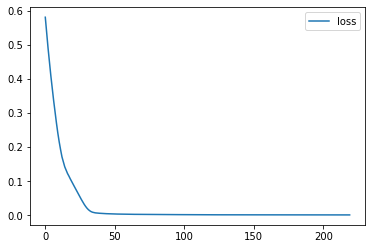

In [10]:
# loss 그래프 생성
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.show()

In [11]:
# 테스트 데이터셋 생성
test_x = np.arange(10, 20, 0.1) 
calc_y = np.cos(test_x) # 10 ~ 20 사이의 x축 범위를 가지는 cos 함수를 값을 0.1 단위로 증가시켜 calc_y 리스트에 저장한다.

In [12]:
# RNN 모델 예측 및 로그 저장
test_y = calc_y[:n_timesteps]
for i in range(len(test_x) - n_timesteps):
  net_input = test_y[i : i+n_timesteps]
  net_input = net_input.reshape((1,n_timesteps, n_features))
  train_y = model.predict(net_input, verbose=0)
  print(test_y.shape, train_y.shape, i, i+n_timesteps)
  test_y=np.append(test_y, train_y)

(15,) (1, 1) 0 15
(16,) (1, 1) 1 16
(17,) (1, 1) 2 17
(18,) (1, 1) 3 18
(19,) (1, 1) 4 19
(20,) (1, 1) 5 20
(21,) (1, 1) 6 21
(22,) (1, 1) 7 22
(23,) (1, 1) 8 23
(24,) (1, 1) 9 24
(25,) (1, 1) 10 25
(26,) (1, 1) 11 26
(27,) (1, 1) 12 27
(28,) (1, 1) 13 28
(29,) (1, 1) 14 29
(30,) (1, 1) 15 30
(31,) (1, 1) 16 31
(32,) (1, 1) 17 32
(33,) (1, 1) 18 33
(34,) (1, 1) 19 34
(35,) (1, 1) 20 35
(36,) (1, 1) 21 36
(37,) (1, 1) 22 37
(38,) (1, 1) 23 38
(39,) (1, 1) 24 39
(40,) (1, 1) 25 40
(41,) (1, 1) 26 41
(42,) (1, 1) 27 42
(43,) (1, 1) 28 43
(44,) (1, 1) 29 44
(45,) (1, 1) 30 45
(46,) (1, 1) 31 46
(47,) (1, 1) 32 47
(48,) (1, 1) 33 48
(49,) (1, 1) 34 49
(50,) (1, 1) 35 50
(51,) (1, 1) 36 51
(52,) (1, 1) 37 52
(53,) (1, 1) 38 53
(54,) (1, 1) 39 54
(55,) (1, 1) 40 55
(56,) (1, 1) 41 56
(57,) (1, 1) 42 57
(58,) (1, 1) 43 58
(59,) (1, 1) 44 59
(60,) (1, 1) 45 60
(61,) (1, 1) 46 61
(62,) (1, 1) 47 62
(63,) (1, 1) 48 63
(64,) (1, 1) 49 64
(65,) (1, 1) 50 65
(66,) (1, 1) 51 66
(67,) (1, 1) 52 67
(68

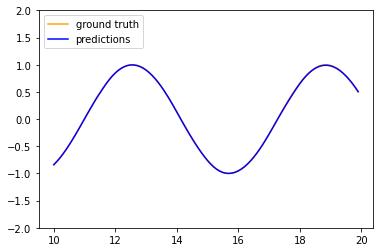

In [13]:
# 예측 결과 그래프 그리기
plt.plot(test_x, calc_y, label="ground truth", color="orange")
plt.plot(test_x, test_y, label="predictions", color="blue")

plt.legend(loc='upper left')
plt.ylim(-2, 2)
plt.show()

RNN 모델보다 오차가 더 작아보이며, 그래프에서 두 개의 sin 파형이 겹쳐보인다.